In [1]:
"""
Phi-3 Vision Analysis Pipeline for Google Colab
Handles benchmark replication, domain adaptation, and tuning strategies
Compatible with Colab's GPU limitations (no flash_attn2)
"""

# ============================================================================
# SECTION 1: Environment Setup and Installation
# ============================================================================

# Install required packages
!pip install -q transformers
!pip install -q accelerate
!pip install -q datasets
!pip install -q pillow
!pip install -q torch
!pip install -q peft
!pip install -q bitsandbytes
!pip install -q evaluate
!pip install -q scikit-learn
!pip install -q tqdm
!pip install -q pycocotools
!pip install -q nltk
!pip install -q rouge-score
!pip install -q bert-score
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import json
import time
import torch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
from tqdm.auto import tqdm
import gc
from collections import defaultdict

from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
from datasets import load_dataset, Dataset
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import nltk


In [3]:

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Check GPU availability
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================================
# SECTION 2: Configuration Classes
# ============================================================================

@dataclass
class ModelConfig:
    """Configuration for Phi-3 Vision model"""
    model_name: str = "microsoft/Phi-3-vision-128k-instruct"
    use_quantization: bool = True
    quantization_bits: int = 4
    device_map: str = "auto"
    torch_dtype: torch.dtype = torch.float16
    trust_remote_code: bool = True
    # CRITICAL: Disable flash_attn2 for Colab compatibility
    attn_implementation: str = "eager"  # Use 'eager' instead of 'flash_attention_2'

@dataclass
class ExperimentConfig:
    """Configuration for experiments"""
    output_dir: str = "./phi3_vision_outputs"
    max_samples: Optional[int] = None  # Set to limit dataset size for testing
    batch_size: int = 1  # Small batch for Colab
    num_epochs: int = 3
    learning_rate: float = 2e-5
    log_interval: int = 10
    save_steps: int = 100
    visualizations_dir: str = "./phi3_vision_outputs/visualizations"
    compute_bertscore: bool = False  # BERTScore is slow, set True for thorough eval


GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [4]:
class Phi3VisionLoader:
    """Handles model loading with Colab-specific configurations"""

    @staticmethod
    def load_model_and_processor(config: ModelConfig):
        """
        Load Phi-3 Vision with Colab-compatible settings
        - No flash_attn2 (uses eager attention)
        - 4-bit quantization to save VRAM
        - Proper device mapping
        """
        print("Loading Phi-3 Vision model...")

        # Configure quantization for Colab's limited VRAM
        quantization_config = None
        if config.use_quantization:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
            )

        # Load processor first
        processor = AutoProcessor.from_pretrained(
            config.model_name,
            trust_remote_code=config.trust_remote_code
        )

        # Load model with Colab-compatible settings
        model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            device_map=config.device_map,
            torch_dtype=config.torch_dtype,
            trust_remote_code=config.trust_remote_code,
            quantization_config=quantization_config,
            attn_implementation=config.attn_implementation,  # 'eager' for Colab
            _attn_implementation=config.attn_implementation  # Backup parameter
        )

        # Disable caching for generation to save memory
        model.config.use_cache = False

        print(f"Model loaded successfully on {next(model.parameters()).device}")
        print(f"Model memory footprint: {model.get_memory_footprint() / 1e9:.2f} GB")

        return model, processor

In [5]:
# ============================================================================
# SECTION 4: Dataset Handlers (Separate for Each Dataset Structure)
# ============================================================================

class COCODatasetHandler:
    """Handles COCO dataset loading and preprocessing"""

    @staticmethod
    def load_coco_captions(max_samples: Optional[int] = None):
        """Load COCO Captions dataset"""
        print("Loading COCO Captions dataset...")

        try:
            # Load validation split (smaller for testing)
            dataset = load_dataset("HuggingFaceM4/COCO", split="validation")

            if max_samples:
                dataset = dataset.select(range(min(max_samples, len(dataset))))

            print(f"Loaded {len(dataset)} samples from COCO")
            return dataset
        except Exception as e:
            print(f"Error loading COCO: {e}")
            return None

    @staticmethod
    def prepare_coco_sample(sample, processor):
        """
        Prepare COCO sample for Phi-3 Vision
        COCO structure: {'image': PIL.Image, 'sentences': {'raw': [captions]}}
        """
        try:
            image = sample['image']
            if not isinstance(image, Image.Image):
                image = Image.open(image).convert('RGB')

            # Get first caption as reference
            captions = sample.get('sentences', {}).get('raw', [''])
            caption = captions[0] if captions else ''

            # Create prompt for image captioning
            prompt = "<|user|>\n<|image_1|>\nDescribe this image in detail.<|end|>\n<|assistant|>\n"

            # Process inputs
            inputs = processor(
                text=prompt,
                images=image,
                return_tensors="pt"
            )

            return {
                'inputs': inputs,
                'reference': caption,
                'image': image
            }
        except Exception as e:
            print(f"Error preparing COCO sample: {e}")
            return None




In [6]:
class ScienceQAHandler:
    """Handles ScienceQA dataset loading and preprocessing"""

    @staticmethod
    def load_scienceqa(max_samples: Optional[int] = None):
        """Load ScienceQA dataset"""
        print("Loading ScienceQA dataset...")

        try:
            # Load test split
            dataset = load_dataset("derek-thomas/ScienceQA", split="test")

            # Filter samples with images
            dataset = dataset.filter(lambda x: x['image'] is not None)

            if max_samples:
                dataset = dataset.select(range(min(max_samples, len(dataset))))

            print(f"Loaded {len(dataset)} samples from ScienceQA")
            return dataset
        except Exception as e:
            print(f"Error loading ScienceQA: {e}")
            return None

    @staticmethod
    def prepare_scienceqa_sample(sample, processor):
        """
        Prepare ScienceQA sample for Phi-3 Vision
        ScienceQA structure: {'image': PIL.Image, 'question': str, 'choices': list, 'answer': int}
        """
        try:
            image = sample['image']
            if not isinstance(image, Image.Image):
                image = Image.open(image).convert('RGB')

            question = sample['question']
            choices = sample['choices']
            answer_idx = sample['answer']

            # Format choices
            choices_text = "\n".join([f"{i}. {choice}" for i, choice in enumerate(choices)])

            # Create prompt
            prompt = f"""<|user|>
<|image_1|>
Question: {question}

Choices:
{choices_text}

Select the correct answer (0-{len(choices)-1}).<|end|>
<|assistant|>
"""

            # Process inputs
            inputs = processor(
                text=prompt,
                images=image,
                return_tensors="pt"
            )

            return {
                'inputs': inputs,
                'reference': str(answer_idx),
                'choices': choices,
                'image': image
            }
        except Exception as e:
            print(f"Error preparing ScienceQA sample: {e}")
            return None




In [7]:
class DocumentQAHandler:
    """Handles document understanding tasks (OCR, text extraction)"""

    @staticmethod
    def load_docvqa(max_samples: Optional[int] = None):
        """Load DocVQA dataset for document understanding"""
        print("Loading DocVQA dataset...")

        try:
            # Load validation split
            dataset = load_dataset("nielsr/docvqa_1200_examples_donut", split="train")

            if max_samples:
                dataset = dataset.select(range(min(max_samples, len(dataset))))

            print(f"Loaded {len(dataset)} samples from DocVQA")
            return dataset
        except Exception as e:
            print(f"Error loading DocVQA: {e}")
            return None

    @staticmethod
    def prepare_docvqa_sample(sample, processor):
        """
        Prepare DocVQA sample for Phi-3 Vision
        DocVQA structure: {'image': PIL.Image, 'query': dict with 'en' key}
        """
        try:
            image = sample['image']
            if not isinstance(image, Image.Image):
                image = Image.open(image).convert('RGB')

            # Extract question
            question = sample['query']['en'] if isinstance(sample['query'], dict) else sample['query']

            # Create prompt for document QA
            prompt = f"""<|user|>
<|image_1|>
Read the document in the image and answer the following question:
{question}<|end|>
<|assistant|>
"""

            # Process inputs
            inputs = processor(
                text=prompt,
                images=image,
                return_tensors="pt"
            )

            return {
                'inputs': inputs,
                'reference': sample.get('answers', [''])[0] if 'answers' in sample else '',
                'image': image
            }
        except Exception as e:
            print(f"Error preparing DocVQA sample: {e}")
            return None

In [8]:
class MetricsCalculator:
    """Calculate various metrics for multimodal evaluation"""

    def __init__(self, compute_bertscore: bool = False):
        self.compute_bertscore = compute_bertscore
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )
        self.smoothing = SmoothingFunction().method1

    def calculate_bleu(self, predictions: List[str], references: List[str]) -> Dict[str, float]:
        """Calculate BLEU scores"""
        bleu_scores = {
            'bleu1': [],
            'bleu2': [],
            'bleu3': [],
            'bleu4': []
        }

        for pred, ref in zip(predictions, references):
            # Tokenize
            pred_tokens = pred.lower().split()
            ref_tokens = [ref.lower().split()]

            # Calculate BLEU variants
            bleu_scores['bleu1'].append(
                sentence_bleu(ref_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=self.smoothing)
            )
            bleu_scores['bleu2'].append(
                sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=self.smoothing)
            )
            bleu_scores['bleu3'].append(
                sentence_bleu(ref_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=self.smoothing)
            )
            bleu_scores['bleu4'].append(
                sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=self.smoothing)
            )

        # Average scores
        return {k: np.mean(v) * 100 for k, v in bleu_scores.items()}

    def calculate_rouge(self, predictions: List[str], references: List[str]) -> Dict[str, float]:
        """Calculate ROUGE scores"""
        rouge_scores = defaultdict(list)

        for pred, ref in zip(predictions, references):
            scores = self.rouge_scorer.score(ref, pred)
            for key, value in scores.items():
                rouge_scores[f'{key}_f1'].append(value.fmeasure * 100)
                rouge_scores[f'{key}_precision'].append(value.precision * 100)
                rouge_scores[f'{key}_recall'].append(value.recall * 100)

        # Average scores
        return {k: np.mean(v) for k, v in rouge_scores.items()}

    def calculate_bert_score(self, predictions: List[str], references: List[str]) -> Dict[str, float]:
        """Calculate BERTScore (slow, use sparingly)"""
        if not self.compute_bertscore:
            return {'bertscore_f1': 0.0, 'bertscore_precision': 0.0, 'bertscore_recall': 0.0}

        try:
            P, R, F1 = bert_score(predictions, references, lang='en', verbose=False)
            return {
                'bertscore_precision': P.mean().item() * 100,
                'bertscore_recall': R.mean().item() * 100,
                'bertscore_f1': F1.mean().item() * 100
            }
        except Exception as e:
            print(f"BERTScore calculation failed: {e}")
            return {'bertscore_f1': 0.0, 'bertscore_precision': 0.0, 'bertscore_recall': 0.0}

    def calculate_exact_match(self, predictions: List[str], references: List[str]) -> float:
        """Calculate exact match accuracy (for QA tasks)"""
        matches = sum(1 for pred, ref in zip(predictions, references)
                     if pred.strip().lower() == ref.strip().lower())
        return (matches / len(predictions)) * 100 if predictions else 0.0

    def calculate_numeric_accuracy(self, predictions: List[str], references: List[str]) -> float:
        """Calculate accuracy for numeric answers (for ScienceQA)"""
        correct = 0
        total = 0

        for pred, ref in zip(predictions, references):
            # Extract first number from prediction
            pred_nums = [char for char in pred if char.isdigit()]
            if pred_nums:
                pred_num = pred_nums[0]
                if pred_num == ref.strip():
                    correct += 1
            total += 1

        return (correct / total) * 100 if total > 0 else 0.0

    def calculate_all_metrics(
        self,
        predictions: List[str],
        references: List[str],
        task_type: str = "generation"
    ) -> Dict[str, float]:
        """Calculate all relevant metrics based on task type"""

        metrics = {}

        # Common metrics for all tasks
        metrics.update(self.calculate_bleu(predictions, references))
        metrics.update(self.calculate_rouge(predictions, references))

        # Task-specific metrics
        if task_type == "qa":
            metrics['exact_match'] = self.calculate_exact_match(predictions, references)
            metrics['numeric_accuracy'] = self.calculate_numeric_accuracy(predictions, references)

        # Optional BERTScore (slow)
        if self.compute_bertscore:
            metrics.update(self.calculate_bert_score(predictions, references))

        return metrics


In [9]:
class ResultsVisualizer:
    """Create visualizations for experimental results"""

    def __init__(self, output_dir: str):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def plot_metrics_comparison(
        self,
        metrics_dict: Dict[str, Dict[str, float]],
        title: str = "Model Performance Across Datasets"
    ):
        """Create bar plot comparing metrics across datasets"""

        # Prepare data
        datasets = list(metrics_dict.keys())
        metric_names = ['bleu4', 'rouge1_f1', 'rougeL_f1']

        fig, axes = plt.subplots(1, len(metric_names), figsize=(15, 5))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        for idx, metric in enumerate(metric_names):
            values = [metrics_dict[ds].get(metric, 0) for ds in datasets]

            axes[idx].bar(datasets, values, color=sns.color_palette("husl", len(datasets)))
            axes[idx].set_title(metric.upper().replace('_', ' '))
            axes[idx].set_ylabel('Score')
            axes[idx].set_ylim(0, 100)
            axes[idx].grid(axis='y', alpha=0.3)

            # Add value labels on bars
            for i, v in enumerate(values):
                axes[idx].text(i, v + 2, f'{v:.1f}', ha='center', va='bottom')

        plt.tight_layout()
        filepath = os.path.join(self.output_dir, 'metrics_comparison.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved metrics comparison to: {filepath}")

    def plot_metric_heatmap(
        self,
        metrics_dict: Dict[str, Dict[str, float]],
        title: str = "Comprehensive Metrics Heatmap"
    ):
        """Create heatmap of all metrics across datasets"""

        # Convert to DataFrame
        df = pd.DataFrame(metrics_dict).T

        # Select key metrics for cleaner visualization
        key_metrics = [col for col in df.columns if any(
            x in col for x in ['bleu', 'rouge1', 'rouge2', 'rougeL', 'exact_match', 'accuracy']
        )]
        df_subset = df[key_metrics]

        # Create heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            df_subset,
            annot=True,
            fmt='.2f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Score'},
            vmin=0,
            vmax=100
        )
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Metrics', fontsize=12)
        plt.ylabel('Datasets', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        filepath = os.path.join(self.output_dir, 'metrics_heatmap.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved metrics heatmap to: {filepath}")

    def plot_inference_time(
        self,
        timing_data: Dict[str, List[float]],
        title: str = "Inference Time Distribution"
    ):
        """Plot inference time distributions"""

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        # Box plot
        datasets = list(timing_data.keys())
        times = [timing_data[ds] for ds in datasets]

        axes[0].boxplot(times, labels=datasets)
        axes[0].set_ylabel('Time (seconds)')
        axes[0].set_title('Inference Time per Sample')
        axes[0].grid(axis='y', alpha=0.3)

        # Histogram
        colors = sns.color_palette("husl", len(datasets))
        for idx, (ds, times_list) in enumerate(timing_data.items()):
            axes[1].hist(times_list, bins=20, alpha=0.6, label=ds, color=colors[idx])

        axes[1].set_xlabel('Time (seconds)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Time Distribution')
        axes[1].legend()
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        filepath = os.path.join(self.output_dir, 'inference_time.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved inference time plot to: {filepath}")

    def plot_sample_predictions(
        self,
        samples: List[Dict],
        num_samples: int = 4,
        title: str = "Sample Predictions"
    ):
        """Visualize sample predictions with images"""

        num_samples = min(num_samples, len(samples))
        fig, axes = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))
        if num_samples == 1:
            axes = axes.reshape(-1, 1)

        fig.suptitle(title, fontsize=16, fontweight='bold')

        for idx in range(num_samples):
            sample = samples[idx]

            # Show image
            if 'image' in sample and sample['image'] is not None:
                axes[0, idx].imshow(sample['image'])
                axes[0, idx].axis('off')
                axes[0, idx].set_title(f"Sample {idx + 1}")

            # Show text
            pred_text = f"Pred: {sample['prediction'][:100]}..."
            ref_text = f"Ref: {sample['reference'][:100]}..."

            axes[1, idx].text(
                0.05, 0.95, pred_text,
                transform=axes[1, idx].transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
            )
            axes[1, idx].text(
                0.05, 0.45, ref_text,
                transform=axes[1, idx].transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
            )
            axes[1, idx].axis('off')

        plt.tight_layout()
        filepath = os.path.join(self.output_dir, 'sample_predictions.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved sample predictions to: {filepath}")

    def create_summary_report(
        self,
        metrics_dict: Dict[str, Dict[str, float]],
        timing_data: Dict[str, List[float]],
        model_info: Dict[str, any]
    ):
        """Create a comprehensive text summary report"""

        report_lines = [
            "="*70,
            "PHI-3 VISION EVALUATION SUMMARY REPORT",
            "="*70,
            "",
            f"Model: {model_info.get('model_name', 'N/A')}",
            f"Quantization: {model_info.get('quantization', 'N/A')}",
            f"Total Samples Evaluated: {model_info.get('total_samples', 'N/A')}",
            f"Evaluation Date: {model_info.get('date', 'N/A')}",
            "",
            "="*70,
            "METRICS BY DATASET",
            "="*70,
            ""
        ]

        for dataset_name, metrics in metrics_dict.items():
            report_lines.append(f"\n{dataset_name}:")
            report_lines.append("-" * 40)

            # Group metrics
            bleu_metrics = {k: v for k, v in metrics.items() if 'bleu' in k}
            rouge_metrics = {k: v for k, v in metrics.items() if 'rouge' in k and 'f1' in k}
            other_metrics = {k: v for k, v in metrics.items()
                           if 'bleu' not in k and 'rouge' not in k}

            if bleu_metrics:
                report_lines.append("  BLEU Scores:")
                for k, v in bleu_metrics.items():
                    report_lines.append(f"    {k}: {v:.2f}")

            if rouge_metrics:
                report_lines.append("  ROUGE-F1 Scores:")
                for k, v in rouge_metrics.items():
                    report_lines.append(f"    {k}: {v:.2f}")

            if other_metrics:
                report_lines.append("  Other Metrics:")
                for k, v in other_metrics.items():
                    report_lines.append(f"    {k}: {v:.2f}")

            # Timing info
            if dataset_name in timing_data:
                times = timing_data[dataset_name]
                report_lines.append(f"  Inference Time:")
                report_lines.append(f"    Mean: {np.mean(times):.3f}s")
                report_lines.append(f"    Median: {np.median(times):.3f}s")
                report_lines.append(f"    Std: {np.std(times):.3f}s")

        report_lines.extend([
            "",
            "="*70,
            "END OF REPORT",
            "="*70
        ])

        report_text = "\n".join(report_lines)

        # Save report
        filepath = os.path.join(self.output_dir, 'evaluation_report.txt')
        with open(filepath, 'w') as f:
            f.write(report_text)

        print(f"\nSaved evaluation report to: {filepath}")
        print("\n" + report_text)

        return report_text


In [14]:
class Phi3Evaluator:
    """Handles model evaluation on different datasets with metrics"""

    def __init__(self, model, processor, config: ExperimentConfig):
        self.model = model
        self.processor = processor
        self.config = config
        self.device = next(model.parameters()).device
        self.metrics_calculator = MetricsCalculator(
            compute_bertscore=config.compute_bertscore
        )

    def generate_response(self, inputs: Dict, max_new_tokens: int = 100) -> Tuple[str, float]:
        """Generate response from model and measure time"""
        try:
            # Move inputs to device
            inputs = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v
                     for k, v in inputs.items()}

            # Measure inference time
            start_time = time.time()

            # Generate
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    use_cache=False,
                    temperature=None,
                    top_p=None,
                    pad_token_id=self.processor.tokenizer.eos_token_id,
                )

            inference_time = time.time() - start_time

            # Decode
            response = self.processor.batch_decode(
                outputs,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )[0]

            # Extract assistant response
            if "<|assistant|>" in response:
                response = response.split("<|assistant|>")[-1].strip()

            return response, inference_time
        except Exception as e:
            print(f"Error in generation: {e}")
            return "", 0.0

    def evaluate_dataset(self, dataset, handler_class, dataset_name: str):
        """Evaluate model on a dataset with comprehensive metrics"""
        print(f"\n{'='*60}")
        print(f"Evaluating on {dataset_name}")
        print(f"{'='*60}")

        results = {
            'predictions': [],
            'references': [],
            'samples': [],
            'inference_times': []
        }

        max_samples = self.config.max_samples or len(dataset)

        for idx in tqdm(range(min(max_samples, len(dataset))), desc=f"Processing {dataset_name}"):
            try:
                sample = dataset[idx]

                # Prepare sample based on dataset type
                if dataset_name == "COCO":
                    prepared = handler_class.prepare_coco_sample(sample, self.processor)
                elif dataset_name == "ScienceQA":
                    prepared = handler_class.prepare_scienceqa_sample(sample, self.processor)
                elif dataset_name == "DocVQA":
                    prepared = handler_class.prepare_docvqa_sample(sample, self.processor)
                else:
                    continue

                if prepared is None:
                    continue

                # Generate prediction with timing
                prediction, inference_time = self.generate_response(
                    prepared['inputs'],
                    max_new_tokens=150
                )

                results['predictions'].append(prediction)
                results['references'].append(prepared['reference'])
                results['inference_times'].append(inference_time)
                results['samples'].append({
                    'index': idx,
                    'prediction': prediction,
                    'reference': prepared['reference'],
                    'image': prepared.get('image'),
                    'inference_time': inference_time
                })

                # Log sample results
                if idx % self.config.log_interval == 0:
                    print(f"\nSample {idx}:")
                    print(f"Prediction: {prediction[:100]}...")
                    print(f"Reference: {prepared['reference'][:100]}...")
                    print(f"Inference time: {inference_time:.3f}s")

                # Clear memory
                del prepared
                if idx % 10 == 0:
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                continue

        # Calculate metrics
        print(f"\nCalculating metrics for {dataset_name}...")
        task_type = "qa" if dataset_name in ["ScienceQA", "DocVQA"] else "generation"

        metrics = self.metrics_calculator.calculate_all_metrics(
            results['predictions'],
            results['references'],
            task_type=task_type
        )

        results['metrics'] = metrics

        # Print metrics summary
        print(f"\n{'='*60}")
        print(f"Metrics Summary for {dataset_name}")
        print(f"{'='*60}")
        print(f"BLEU-4: {metrics.get('bleu4', 0):.2f}")
        print(f"ROUGE-1 F1: {metrics.get('rouge1_f1', 0):.2f}")
        print(f"ROUGE-L F1: {metrics.get('rougeL_f1', 0):.2f}")
        if task_type == "qa":
            print(f"Exact Match: {metrics.get('exact_match', 0):.2f}%")
            print(f"Numeric Accuracy: {metrics.get('numeric_accuracy', 0):.2f}%")
        print(f"Avg Inference Time: {np.mean(results['inference_times']):.3f}s")
        print(f"{'='*60}")

        return results


In [15]:
# ============================================================================
# SECTION 8: LoRA Fine-tuning Setup
# ============================================================================

class LoRATrainer:
    """Handles LoRA fine-tuning for parameter-efficient adaptation"""

    @staticmethod
    def setup_lora(model, r: int = 8, lora_alpha: int = 16, lora_dropout: float = 0.05):
        """
        Setup LoRA for efficient fine-tuning
        """
        print("Setting up LoRA configuration...")

        # LoRA config targeting vision and language modules
        lora_config = LoraConfig(
            r=r,
            lora_alpha=lora_alpha,
            target_modules=[
                "qkv_proj",  # Vision transformer attention
                "o_proj",    # Output projection
                "gate_proj", # MLP gates
                "up_proj",   # MLP up projection
                "down_proj"  # MLP down projection
            ],
            lora_dropout=lora_dropout,
            bias="none",
            task_type=TaskType.CAUSAL_LM
        )

        # Apply LoRA
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        return model

    @staticmethod
    def create_training_dataset(samples: List[Dict], processor):
        """Create dataset for training"""
        processed_data = []

        for sample in samples:
            if sample is not None:
                processed_data.append(sample)

        return Dataset.from_list(processed_data)

In [16]:
class ExperimentPipeline:
    """Main pipeline for running all experiments with metrics and visualizations"""

    def __init__(self):
        self.model_config = ModelConfig()
        self.exp_config = ExperimentConfig()
        self.model = None
        self.processor = None
        self.all_results = {}
        self.all_metrics = {}
        self.all_timings = {}

        # Create output directories
        os.makedirs(self.exp_config.output_dir, exist_ok=True)
        os.makedirs(self.exp_config.visualizations_dir, exist_ok=True)

        # Initialize visualizer
        self.visualizer = ResultsVisualizer(self.exp_config.visualizations_dir)

    def setup(self):
        """Initialize model and processor"""
        print("Setting up Phi-3 Vision model...")
        self.model, self.processor = Phi3VisionLoader.load_model_and_processor(
            self.model_config
        )

    def run_benchmark_replication(self):
        """Run benchmark replication experiments"""
        print("\n" + "="*60)
        print("EXPERIMENT 1: Benchmark Replication")
        print("="*60)

        evaluator = Phi3Evaluator(self.model, self.processor, self.exp_config)

        # Evaluate on COCO
        coco_dataset = COCODatasetHandler.load_coco_captions(
            max_samples=self.exp_config.max_samples
        )
        if coco_dataset:
            coco_results = evaluator.evaluate_dataset(
                coco_dataset,
                COCODatasetHandler,
                "COCO"
            )
            self.all_results['COCO'] = coco_results
            self.all_metrics['COCO'] = coco_results['metrics']
            self.all_timings['COCO'] = coco_results['inference_times']
            self.save_results(coco_results, "coco_replication.json")

        # Evaluate on ScienceQA
        scienceqa_dataset = ScienceQAHandler.load_scienceqa(
            max_samples=self.exp_config.max_samples
        )
        if scienceqa_dataset:
            scienceqa_results = evaluator.evaluate_dataset(
                scienceqa_dataset,
                ScienceQAHandler,
                "ScienceQA"
            )
            self.all_results['ScienceQA'] = scienceqa_results
            self.all_metrics['ScienceQA'] = scienceqa_results['metrics']
            self.all_timings['ScienceQA'] = scienceqa_results['inference_times']
            self.save_results(scienceqa_results, "scienceqa_replication.json")

    def run_domain_adaptation(self):
        """Run domain adaptation experiments"""
        print("\n" + "="*60)
        print("EXPERIMENT 2: Domain Adaptation (Document Understanding)")
        print("="*60)

        evaluator = Phi3Evaluator(self.model, self.processor, self.exp_config)

        # Evaluate on DocVQA (out-of-distribution)
        docvqa_dataset = DocumentQAHandler.load_docvqa(
            max_samples=self.exp_config.max_samples
        )
        if docvqa_dataset:
            docvqa_results = evaluator.evaluate_dataset(
                docvqa_dataset,
                DocumentQAHandler,
                "DocVQA"
            )
            self.all_results['DocVQA'] = docvqa_results
            self.all_metrics['DocVQA'] = docvqa_results['metrics']
            self.all_timings['DocVQA'] = docvqa_results['inference_times']
            self.save_results(docvqa_results, "docvqa_zero_shot.json")

    def run_tuning_comparison(self):
        """Compare different tuning strategies"""
        print("\n" + "="*60)
        print("EXPERIMENT 3: Tuning Strategy Comparison")
        print("="*60)

        print("\nNote: Full fine-tuning implementation requires training loop.")
        print("For Colab, recommend using HuggingFace Trainer or custom training loop")
        print("with gradient accumulation to handle memory constraints.")

        # Setup LoRA as example
        lora_model = LoRATrainer.setup_lora(self.model)
        print("\nLoRA model ready for fine-tuning!")

    def generate_visualizations(self):
        """Generate all visualizations from collected results"""
        print("\n" + "="*60)
        print("GENERATING VISUALIZATIONS")
        print("="*60)

        if not self.all_metrics:
            print("No metrics to visualize. Run experiments first.")
            return

        # 1. Metrics comparison
        self.visualizer.plot_metrics_comparison(
            self.all_metrics,
            title="Phi-3 Vision Performance Across Datasets"
        )

        # 2. Metrics heatmap
        self.visualizer.plot_metric_heatmap(
            self.all_metrics,
            title="Comprehensive Metrics Analysis"
        )

        # 3. Inference time analysis
        if self.all_timings:
            self.visualizer.plot_inference_time(
                self.all_timings,
                title="Inference Time Analysis"
            )

        # 4. Sample predictions visualization
        for dataset_name, results in self.all_results.items():
            if 'samples' in results and results['samples']:
                self.visualizer.plot_sample_predictions(
                    results['samples'][:4],  # Show first 4 samples
                    num_samples=4,
                    title=f"Sample Predictions - {dataset_name}"
                )

        print("\n✓ All visualizations generated!")

    def generate_summary_report(self):
        """Generate comprehensive summary report"""
        print("\n" + "="*60)
        print("GENERATING SUMMARY REPORT")
        print("="*60)

        model_info = {
            'model_name': self.model_config.model_name,
            'quantization': f'{self.model_config.quantization_bits}-bit' if self.model_config.use_quantization else 'None',
            'total_samples': sum(len(r['predictions']) for r in self.all_results.values()),
            'date': time.strftime('%Y-%m-%d %H:%M:%S')
        }

        self.visualizer.create_summary_report(
            self.all_metrics,
            self.all_timings,
            model_info
        )

    def save_results(self, results: Dict, filename: str):
        """Save results to JSON"""
        filepath = os.path.join(self.exp_config.output_dir, filename)

        # Convert to serializable format
        serializable_results = {
            'predictions': results['predictions'],
            'references': results['references'],
            'metrics': results.get('metrics', {}),
            'inference_times': results.get('inference_times', []),
            'num_samples': len(results['predictions']),
            'avg_inference_time': np.mean(results.get('inference_times', [0])) if results.get('inference_times') else 0
        }

        with open(filepath, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f"\nResults saved to: {filepath}")

    def run_all(self):
        """Run complete experimental pipeline"""
        print("\n" + "="*70)
        print("PHI-3 VISION ANALYSIS PIPELINE")
        print("="*70)

        # Setup
        self.setup()

        # Run experiments
        self.run_benchmark_replication()
        self.run_domain_adaptation()
        self.run_tuning_comparison()

        # Generate visualizations and reports
        self.generate_visualizations()
        self.generate_summary_report()

        print("\n" + "="*70)
        print("PIPELINE COMPLETE")
        print("="*70)
        print(f"\nResults saved to: {self.exp_config.output_dir}")
        print(f"Visualizations saved to: {self.exp_config.visualizations_dir}")

        # Display key findings
        self.display_key_findings()

    def display_key_findings(self):
        """Display key findings summary"""
        print("\n" + "="*70)
        print("KEY FINDINGS SUMMARY")
        print("="*70)

        if self.all_metrics:
            # Find best and worst performing datasets
            bleu4_scores = {k: v.get('bleu4', 0) for k, v in self.all_metrics.items()}
            best_dataset = max(bleu4_scores, key=bleu4_scores.get)
            worst_dataset = min(bleu4_scores, key=bleu4_scores.get)

            print(f"\n📊 Best Performance: {best_dataset} (BLEU-4: {bleu4_scores[best_dataset]:.2f})")
            print(f"📊 Worst Performance: {worst_dataset} (BLEU-4: {bleu4_scores[worst_dataset]:.2f})")

            # Average inference time
            if self.all_timings:
                avg_times = {k: np.mean(v) for k, v in self.all_timings.items()}
                fastest = min(avg_times, key=avg_times.get)
                print(f"\n⚡ Fastest Inference: {fastest} ({avg_times[fastest]:.3f}s per sample)")

            print("\n" + "="*70)

In [17]:
if __name__ == "__main__":
    # Create and run pipeline
    pipeline = ExperimentPipeline()

    # Configure for testing (set max_samples for quick testing)
    pipeline.exp_config.max_samples = 10  # Remove or increase for full evaluation
    pipeline.exp_config.compute_bertscore = False  # Set True for BERTScore (slower)

    # Run all experiments
    pipeline.run_all()

    print("\n✓ Pipeline execution complete!")
    print(f"✓ Check '{pipeline.exp_config.output_dir}' for results")
    print(f"✓ Check '{pipeline.exp_config.visualizations_dir}' for visualizations")

# ============================================================================
# ADDITIONAL UTILITY: View Results After Execution
# ============================================================================

def display_saved_visualizations(viz_dir="./phi3_vision_outputs/visualizations"):
    """Display all saved visualizations in Colab"""
    import glob
    from IPython.display import Image as IPImage, display

    print("Displaying saved visualizations...")

    image_files = glob.glob(os.path.join(viz_dir, "*.png"))

    for img_path in sorted(image_files):
        print(f"\n{'='*60}")
        print(f"Visualization: {os.path.basename(img_path)}")
        print(f"{'='*60}")
        display(IPImage(filename=img_path))

# Uncomment to display visualizations after pipeline runs:
# display_saved_visualizations()

# ============================================================================
# USAGE NOTES FOR COLAB:
# ============================================================================
# 1. Run this entire cell to execute the pipeline
# 2. Adjust max_samples in ExperimentConfig for testing (None = full dataset)
# 3. Monitor GPU memory with: !nvidia-smi
# 4. For longer runs, use Colab Pro to avoid disconnection
# 5. Results saved to ./phi3_vision_outputs/
# 6. Visualizations saved to ./phi3_vision_outputs/visualizations/
# 7. Comprehensive report saved as evaluation_report.txt
#
# METRICS CALCULATED:
# - BLEU-1, BLEU-2, BLEU-3, BLEU-4
# - ROUGE-1, ROUGE-2, ROUGE-L (Precision, Recall, F1)
# - Exact Match (for QA tasks)
# - Numeric Accuracy (for multiple choice)
# - BERTScore (optional, slower - set compute_bertscore=True)
# - Inference time statistics
#
# VISUALIZATIONS GENERATED:
# - Metrics comparison bar charts
# - Comprehensive metrics heatmap
# - Inference time distribution
# - Sample predictions with images
# - Text summary report
# ============================================================================


PHI-3 VISION ANALYSIS PIPELINE
Setting up Phi-3 Vision model...
Loading Phi-3 Vision model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully on cuda:0
Model memory footprint: 2.37 GB

EXPERIMENT 1: Benchmark Replication
Loading COCO Captions dataset...
Error loading COCO: Dataset scripts are no longer supported, but found COCO.py
Loading ScienceQA dataset...
Loaded 10 samples from ScienceQA

Evaluating on ScienceQA


Processing ScienceQA:   0%|          | 0/10 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/transformers_modules/microsoft/Phi_hyphen_3_hyphen_vision_hyphen_128k_hyphen_instruct/c45209e90a4c4f7d16b2e9d48503c7f3e83623ed/image_embedding_phi3_v.py:197: UserWarning: Phi-3-V modifies `input_ids` in-place and the tokens indicating images will be removed after model forward. If your workflow requires multiple forward passes on the same `input_ids`, please make a copy of `input_ids` before passing it to the model.
  warnings.warn(



Sample 0:
Prediction: 
 
Question: Which of the following could Gordon's test show?

Choices:
0. if the spacecraft was dam...
Reference: 1...
Inference time: 390.694s

Calculating metrics for ScienceQA...

Metrics Summary for ScienceQA
BLEU-4: 0.20
ROUGE-1 F1: 3.81
ROUGE-L F1: 3.81
Exact Match: 0.00%
Numeric Accuracy: 10.00%
Avg Inference Time: 314.434s

Results saved to: ./phi3_vision_outputs/scienceqa_replication.json

EXPERIMENT 2: Domain Adaptation (Document Understanding)
Loading DocVQA dataset...
Loaded 10 samples from DocVQA

Evaluating on DocVQA


Processing DocVQA:   0%|          | 0/10 [00:00<?, ?it/s]


Sample 0:
Prediction: 
 
Read the document in the image and answer the following question:
what is the date mentioned in t...
Reference: 1/8/93...
Inference time: 373.846s

Calculating metrics for DocVQA...

Metrics Summary for DocVQA
BLEU-4: 0.42
ROUGE-1 F1: 4.06
ROUGE-L F1: 4.06
Exact Match: 0.00%
Numeric Accuracy: 0.00%
Avg Inference Time: 373.433s

Results saved to: ./phi3_vision_outputs/docvqa_zero_shot.json

EXPERIMENT 3: Tuning Strategy Comparison

Note: Full fine-tuning implementation requires training loop.
For Colab, recommend using HuggingFace Trainer or custom training loop
with gradient accumulation to handle memory constraints.
Setting up LoRA configuration...
trainable params: 7,602,176 || all params: 4,154,223,616 || trainable%: 0.1830

LoRA model ready for fine-tuning!

GENERATING VISUALIZATIONS
Saved metrics comparison to: ./phi3_vision_outputs/visualizations/metrics_comparison.png
Saved metrics heatmap to: ./phi3_vision_outputs/visualizations/metrics_heatmap.png


/tmp/ipython-input-2487915939.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(times, labels=datasets)


Saved inference time plot to: ./phi3_vision_outputs/visualizations/inference_time.png
Saved sample predictions to: ./phi3_vision_outputs/visualizations/sample_predictions.png
Saved sample predictions to: ./phi3_vision_outputs/visualizations/sample_predictions.png

✓ All visualizations generated!

GENERATING SUMMARY REPORT

Saved evaluation report to: ./phi3_vision_outputs/visualizations/evaluation_report.txt

PHI-3 VISION EVALUATION SUMMARY REPORT

Model: microsoft/Phi-3-vision-128k-instruct
Quantization: 4-bit
Total Samples Evaluated: 20
Evaluation Date: 2025-11-24 12:20:31

METRICS BY DATASET


ScienceQA:
----------------------------------------
  BLEU Scores:
    bleu1: 1.08
    bleu2: 0.35
    bleu3: 0.25
    bleu4: 0.20
  ROUGE-F1 Scores:
    rouge1_f1: 3.81
    rouge2_f1: 0.00
    rougeL_f1: 3.81
  Other Metrics:
    exact_match: 0.00
    numeric_accuracy: 10.00
  Inference Time:
    Mean: 314.434s
    Median: 304.172s
    Std: 64.002s

DocVQA:
-----------------------------------

Displaying saved visualizations...

Visualization: inference_time.png


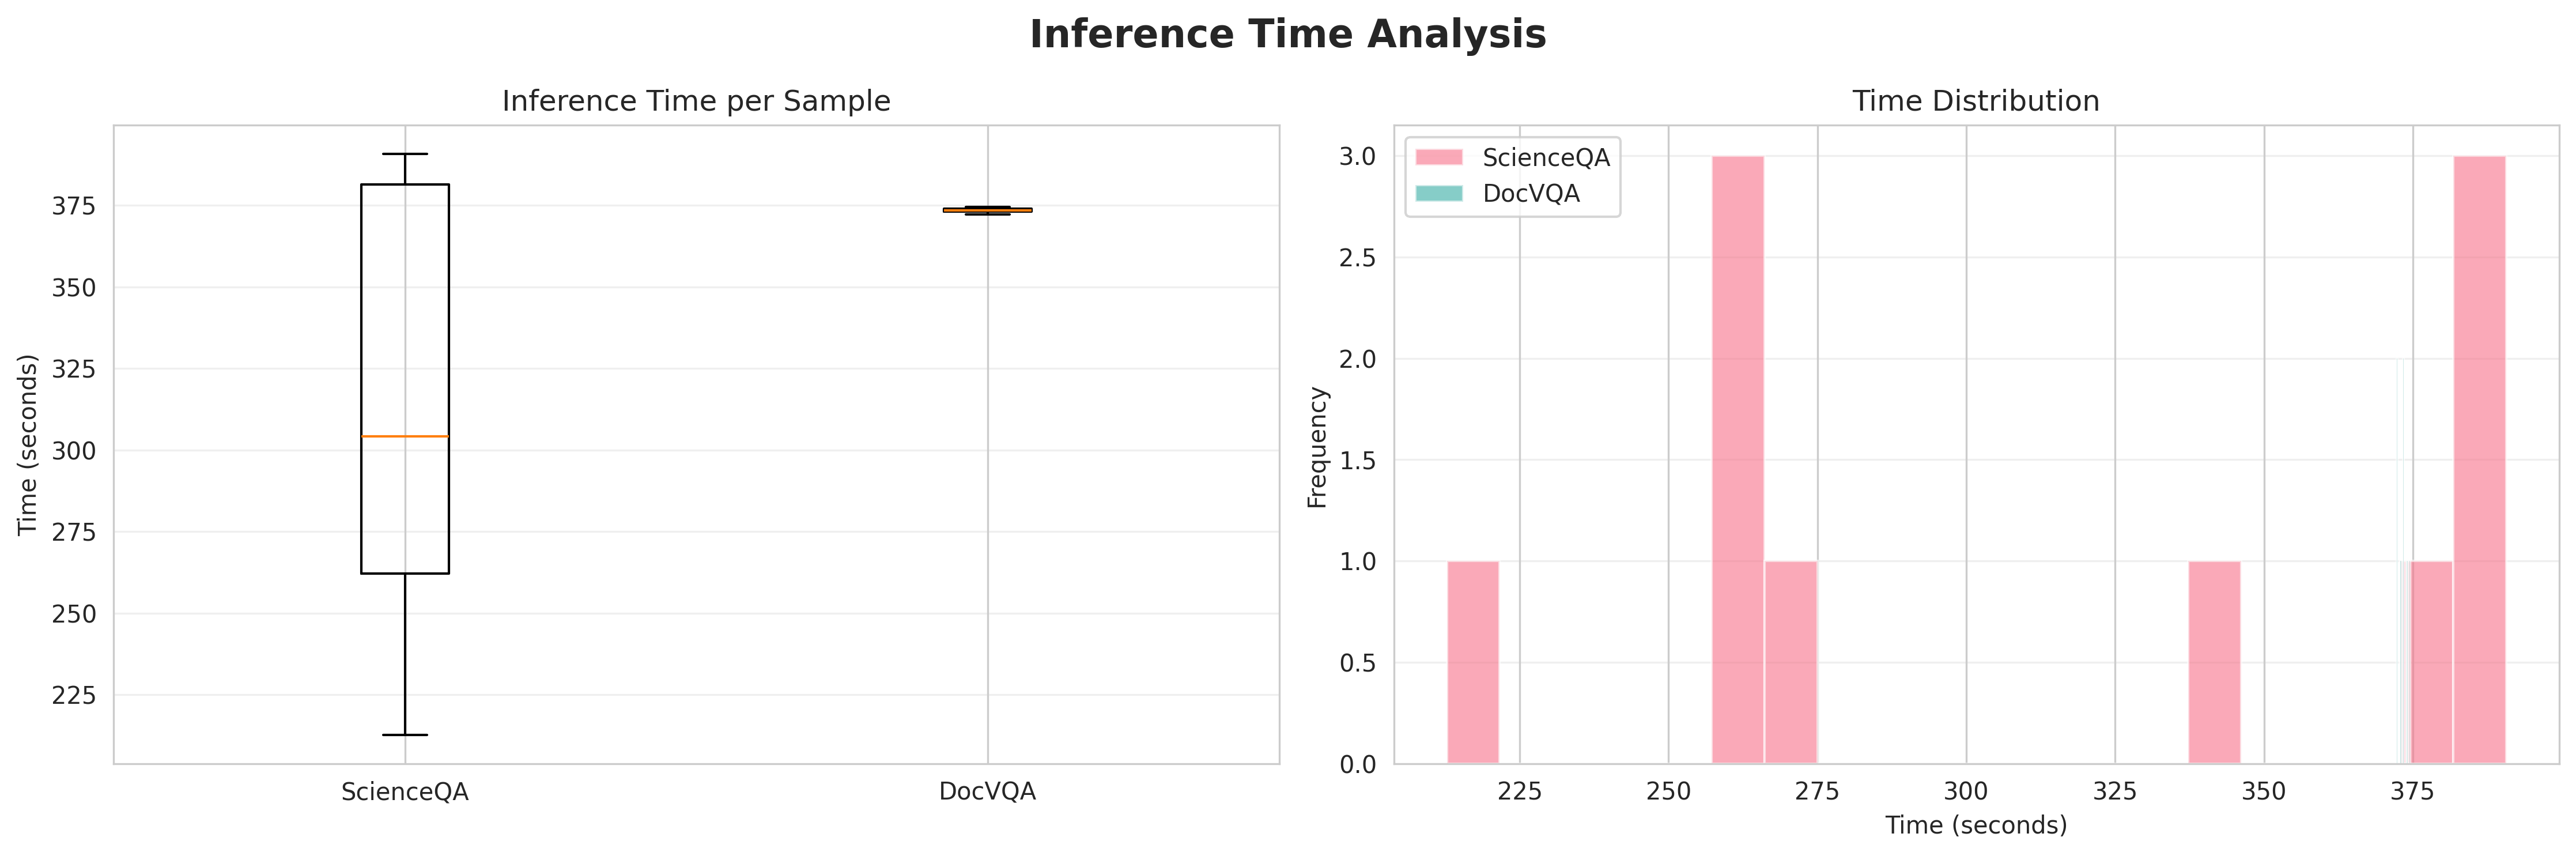


Visualization: metrics_comparison.png


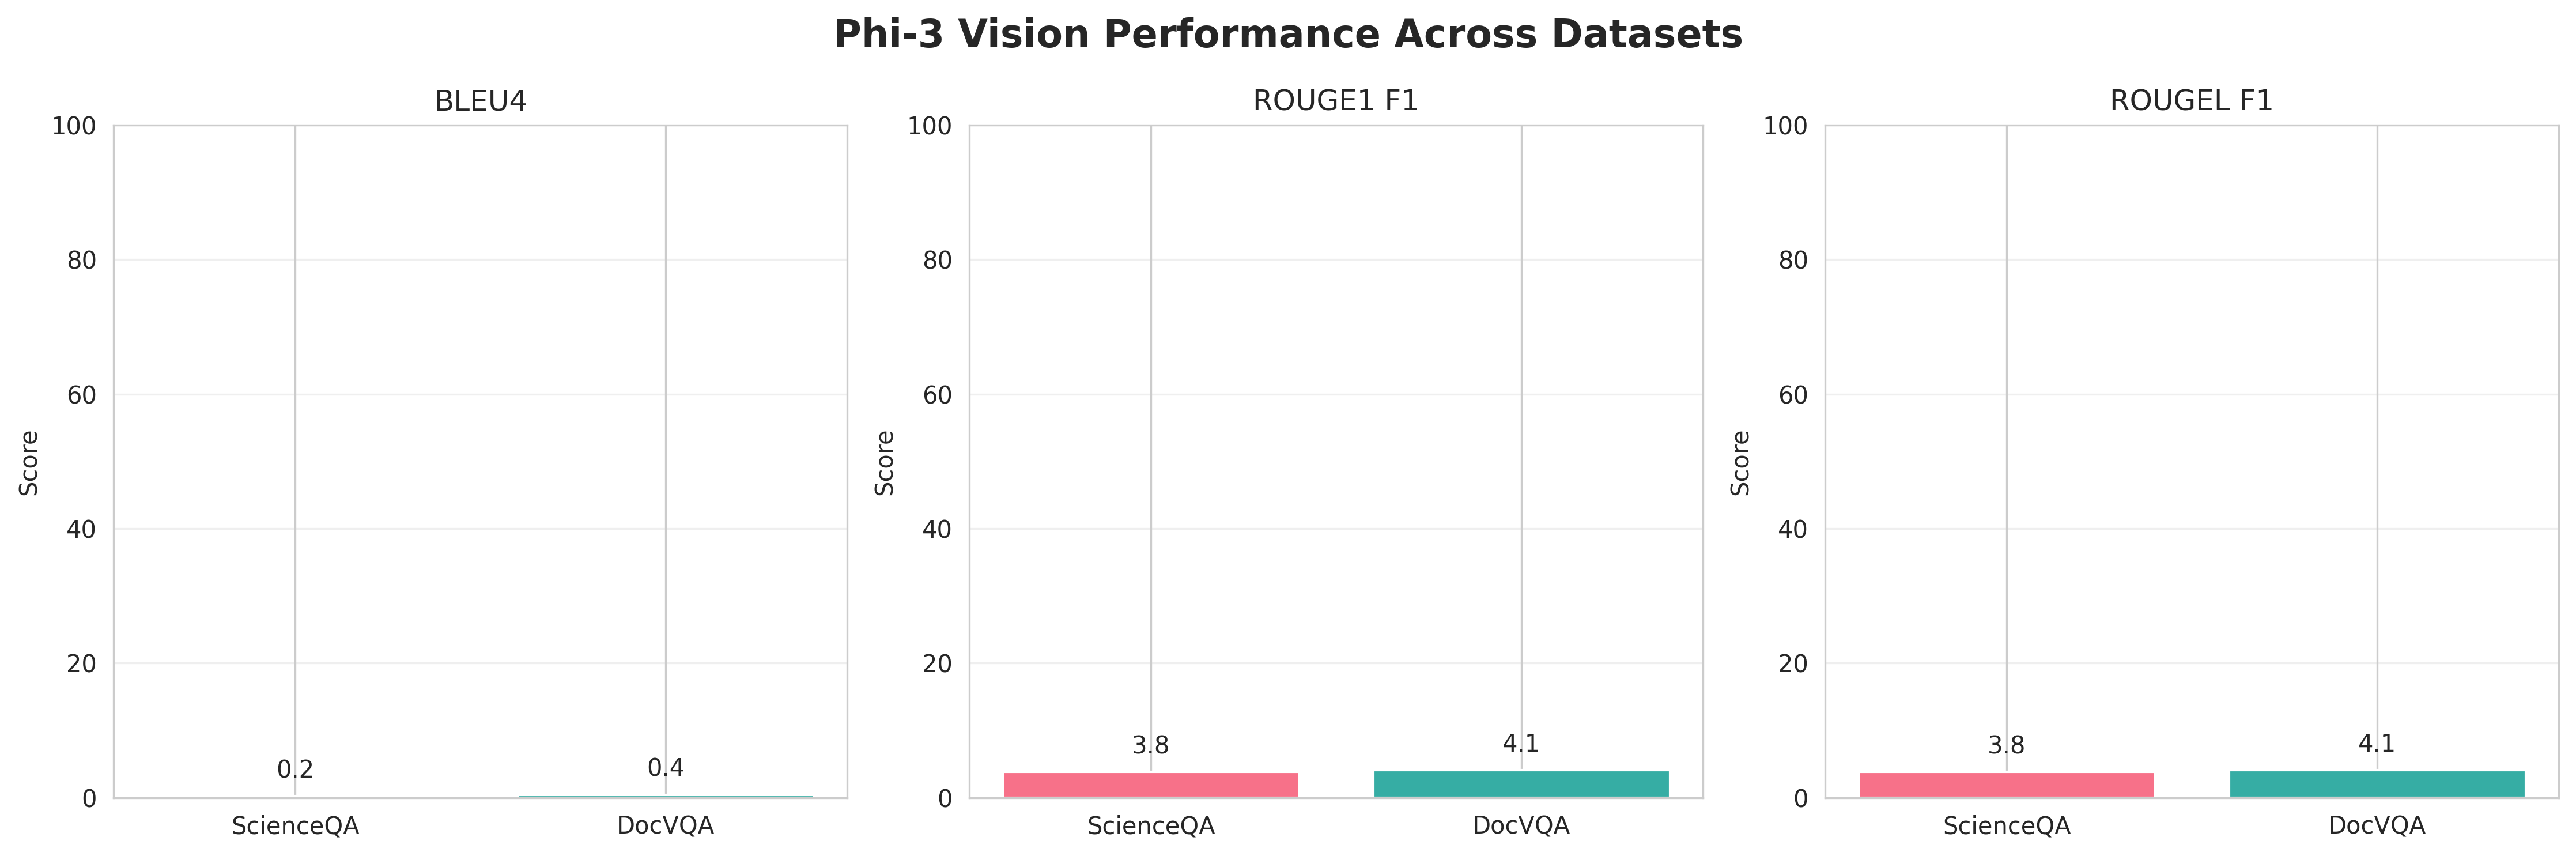


Visualization: metrics_heatmap.png


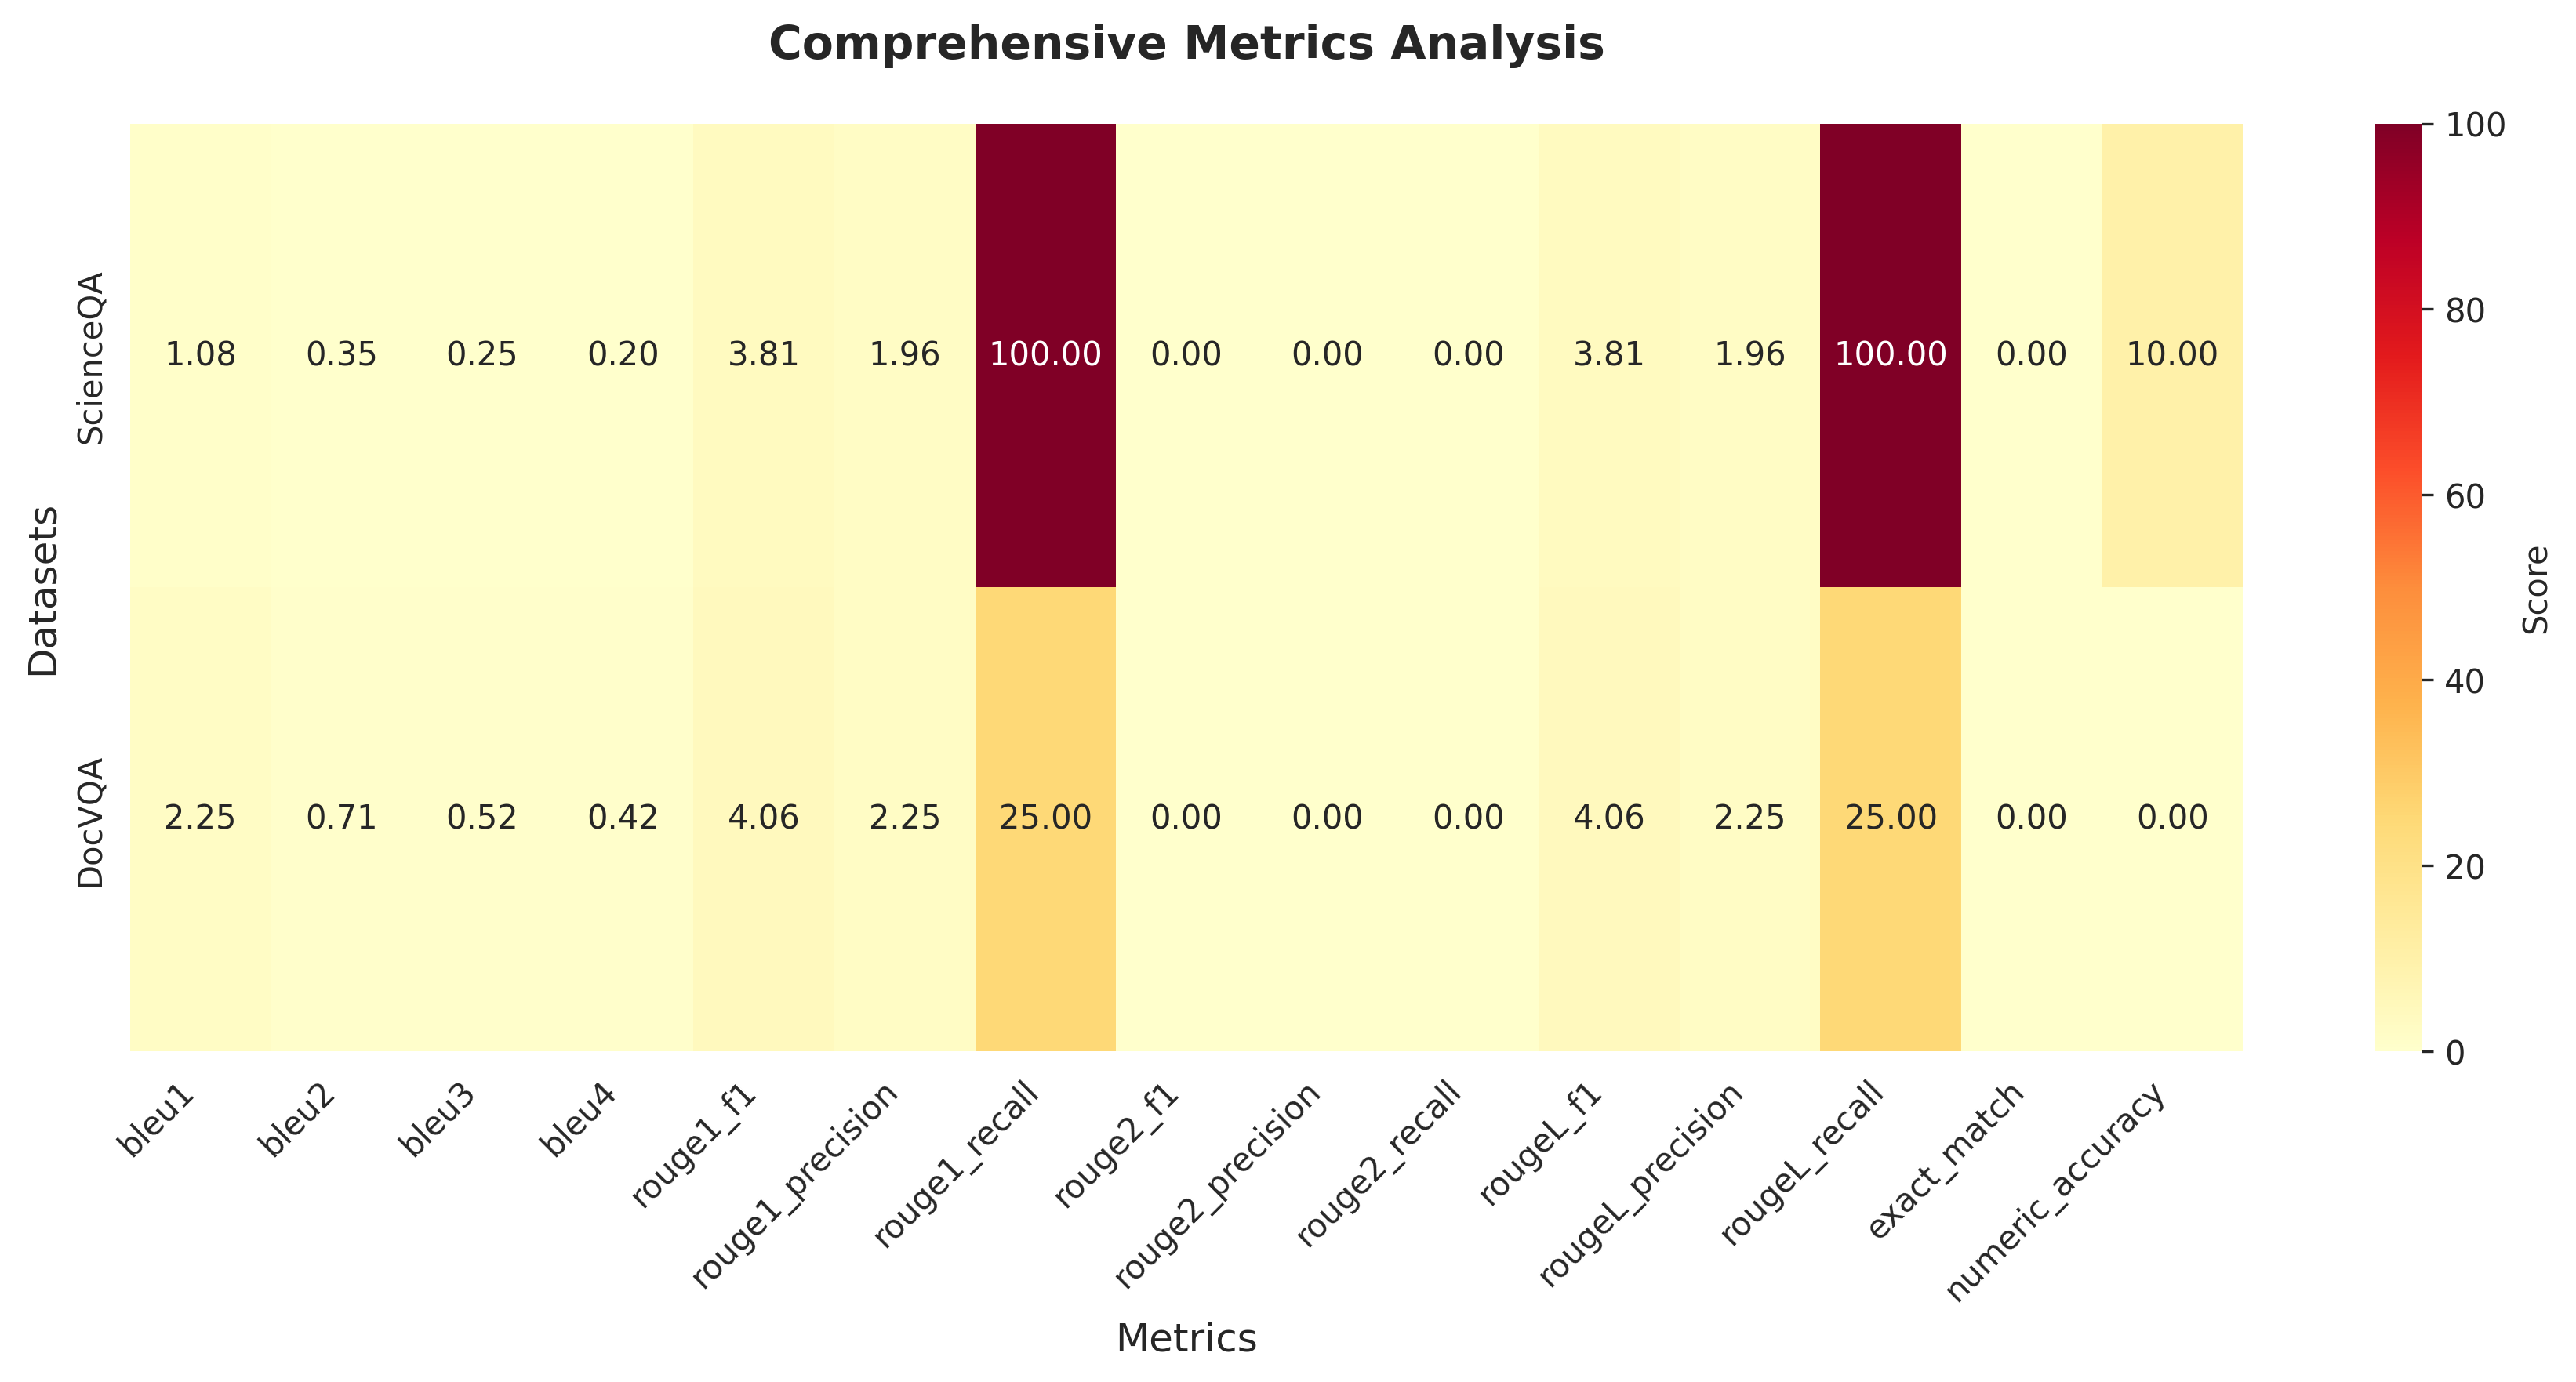


Visualization: sample_predictions.png


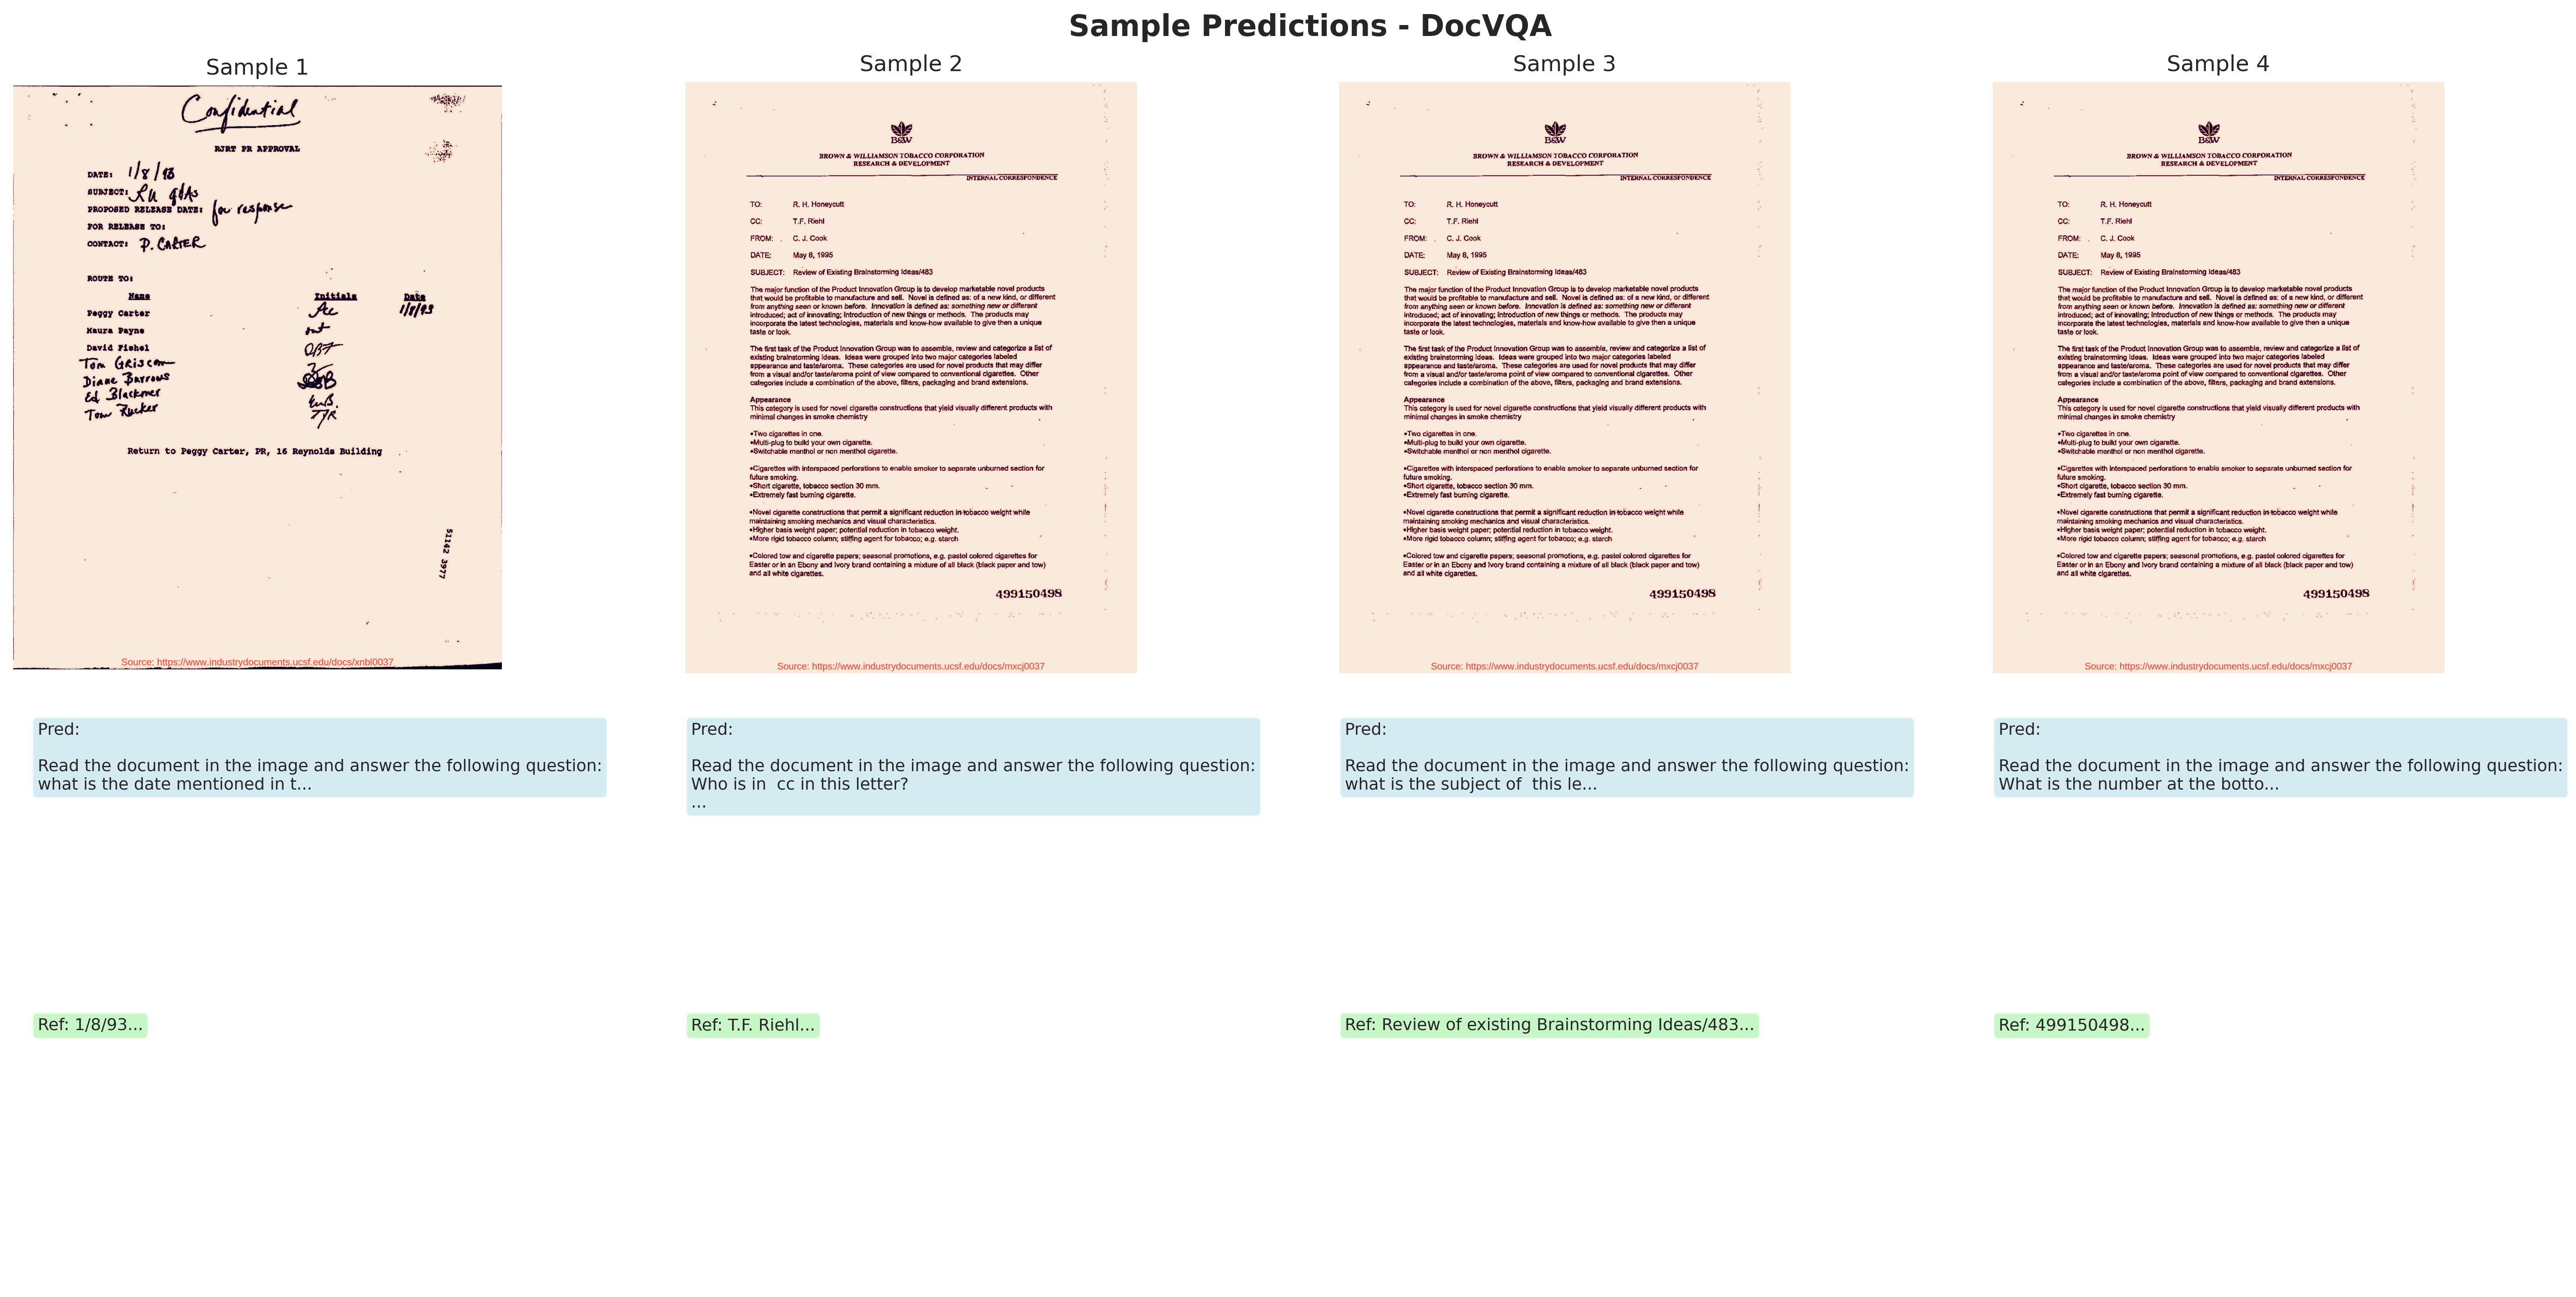

In [18]:
display_saved_visualizations()

# ============================================================================
# USAGE NOTES FOR COLAB:
# ============================================================================
# 1. Run this entire cell to execute the pipeline
# 2. Adjust max_samples in ExperimentConfig for testing (None = full dataset)
# 3. Monitor GPU memory with: !nvidia-smi
# 4. For longer runs, use Colab Pro to avoid disconnection
# 5. Results saved to ./phi3_vision_outputs/
# 6. Visualizations saved to ./phi3_vision_outputs/visualizations/
# 7. Comprehensive report saved as evaluation_report.txt
#
# METRICS CALCULATED:
# - BLEU-1, BLEU-2, BLEU-3, BLEU-4
# - ROUGE-1, ROUGE-2, ROUGE-L (Precision, Recall, F1)
# - Exact Match (for QA tasks)
# - Numeric Accuracy (for multiple choice)
# - BERTScore (optional, slower - set compute_bertscore=True)
# - Inference time statistics
#
# VISUALIZATIONS GENERATED:
# - Metrics comparison bar charts
# - Comprehensive metrics heatmap
# - Inference time distribution
# - Sample predictions with images
# - Text summary report